In [36]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np

In [37]:
df = pd.read_csv('Resources/sales.csv')
# df = df.drop(columns= ['Unnamed: 0'], axis=1)
df.head()

,Date,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year,promotion
0,2010-02-05,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5,1
1,2010-02-12,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6,1
2,2010-02-19,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7,1
3,2010-02-26,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8,1
4,2010-03-05,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9,0


In [38]:
df=df.drop(columns=['Date'])
df.head()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year,promotion
0,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5,1
1,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6,1
2,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7,1
3,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8,1
4,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9,0


In [39]:
df=df[['Store','Product','month','day', 'year','week_of_year','Is_Holiday','Base Price','Price','promotion','weekly_sales','Weekly_Units_Sold']]
df.head()

,Store,Product,month,day,year,week_of_year,Is_Holiday,Base Price,Price,promotion,weekly_sales,Weekly_Units_Sold
0,1,1,2,5,2010,5,False,9.99,7.99,1,1957.55,245
1,1,1,2,12,2010,6,True,9.99,7.99,1,3619.47,453
2,1,1,2,19,2010,7,False,9.99,7.99,1,3267.91,409
3,1,1,2,26,2010,8,False,9.99,7.99,1,1526.09,191
4,1,1,3,5,2010,9,False,9.99,9.99,0,1448.55,145


In [40]:
df['Is_Holiday']=LabelEncoder().fit_transform(df['Is_Holiday'])
df.head()

# # Add new column, Promotion. 
# def f(row):

#     # If base price and price are the same promotion is 0 or no. 
#     if row['Is_Holiday'] == row[False]:
#         val = 0

#     #  If base price is higher than price promotion is 1 or yes.
#     elif row['Is_Holiday'] == row[True]:
#         val = 1

#     # Hopefully there are no instances where price is higher than base price. 
#     else:
#         val = -1
#     return val
# df['Is_Holiday'] = df.apply(f, axis=1)
# df.head()

,Store,Product,month,day,year,week_of_year,Is_Holiday,Base Price,Price,promotion,weekly_sales,Weekly_Units_Sold
0,1,1,2,5,2010,5,0,9.99,7.99,1,1957.55,245
1,1,1,2,12,2010,6,1,9.99,7.99,1,3619.47,453
2,1,1,2,19,2010,7,0,9.99,7.99,1,3267.91,409
3,1,1,2,26,2010,8,0,9.99,7.99,1,1526.09,191
4,1,1,3,5,2010,9,0,9.99,9.99,0,1448.55,145


In [41]:
# Create features
X=df.drop(columns=['Weekly_Units_Sold'], axis = 1)
X=pd.get_dummies(X)

# Create target. 
y = df['Weekly_Units_Sold']

In [42]:
X

,Store,Product,month,day,year,week_of_year,Is_Holiday,Base Price,Price,promotion,weekly_sales
0,1,1,2,5,2010,5,0,9.99,7.99,1,1957.55
1,1,1,2,12,2010,6,1,9.99,7.99,1,3619.47
2,1,1,2,19,2010,7,0,9.99,7.99,1,3267.91
3,1,1,2,26,2010,8,0,9.99,7.99,1,1526.09
4,1,1,3,5,2010,9,0,9.99,9.99,0,1448.55
...,...,...,...,...,...,...,...,...,...,...,...
3856,10,3,9,28,2012,39,0,19.99,19.99,0,2658.67
3857,10,3,10,5,2012,40,0,19.99,19.99,0,2658.67
3858,10,3,10,12,2012,41,0,19.99,19.99,0,2538.73
3859,10,3,10,19,2012,42,0,19.99,19.99,0,2658.67


In [43]:
X.describe()

,Store,Product,month,day,year,week_of_year,Is_Holiday,Base Price,Price,promotion,weekly_sales
count,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000
mean,5.111111,2.000000,6.447552,15.678322,2010.965035,25.818182,0.069930,12.554103,11.766084,0.172494,1896.054685
std,2.767003,0.816602,3.238476,8.756234,0.797061,14.129933,0.255062,6.079043,5.976196,0.377858,1789.384621
min,1.000000,1.000000,1.000000,1.000000,2010.000000,1.000000,0.000000,5.990000,4.010000,0.000000,229.770000
25%,3.000000,1.000000,4.000000,8.000000,2010.000000,14.000000,0.000000,6.990000,5.990000,0.000000,778.700000
50%,5.000000,2.000000,6.000000,16.000000,2011.000000,26.000000,0.000000,10.990000,10.000000,0.000000,1476.720000
75%,7.000000,3.000000,9.000000,23.000000,2012.000000,38.000000,0.000000,19.990000,19.990000,0.000000,2330.110000
max,10.000000,3.000000,12.000000,31.000000,2012.000000,52.000000,1.000000,21.990000,21.990000,1.000000,25570.000000


In [44]:
# Scale the data
scaler = StandardScaler().fit(X)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [46]:
X_test

,Store,Product,month,day,year,week_of_year,Is_Holiday,Base Price,Price,promotion,weekly_sales
1135,3,2,8,31,2012,35,0,6.99,6.99,0,775.89
1857,5,1,10,19,2012,42,0,10.99,10.99,0,703.36
2480,6,3,1,14,2011,2,0,21.99,21.99,0,1737.21
988,3,1,8,3,2012,31,0,10.99,10.99,0,461.58
102,1,1,1,20,2012,3,0,10.99,10.99,0,1164.94
...,...,...,...,...,...,...,...,...,...,...,...
3468,10,1,10,15,2010,41,0,9.99,9.99,0,2977.02
345,1,3,3,25,2011,12,0,21.99,21.99,0,1143.48
993,3,1,9,7,2012,36,1,10.99,10.99,0,516.53
1125,3,2,6,22,2012,25,0,6.99,6.99,0,747.93


In [47]:
def rmse(X, predictions):
    return np.sqrt(np.mean(np.square(X - predictions)))

In [48]:
# Create and train the model
model = LinearRegression().fit(X_train, y_train)

# Generate predictions
predictions_test = model.predict(X_test)

# Compute loss to evalute the model
loss = rmse(y_test, predictions_test)
print('Test Loss for LinearRegression:', loss)

# Generate predictions for train set
predictions_train = model.predict(X_train)

# Compute loss on train set to evalute the model
loss = rmse(y_train, predictions_train)
print('Training Loss for LinearRegression:', loss)

Test Loss for LinearRegression: 87.62139390028145
Training Loss for LinearRegression: 90.77634655812832


In [12]:
# # Scale the data
# scaler = StandardScaler().fit(X_train)

In [13]:
# model=LinearRegression()

In [14]:
# model.fit(X_train, y_train)

In [49]:
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.8465337400228753
Testing Score: 0.8764360812673717


In [50]:
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.8548749158371453


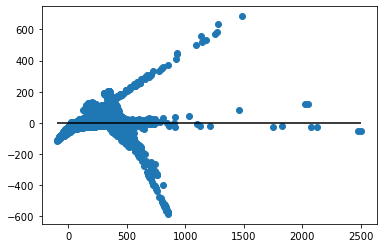

In [51]:
predictions = model.predict(X)
# Plot Residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [18]:
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

In [19]:
# USE WEIRD MAGICAL FUNCTIONS TO FIT THE CASE DATA TO A SECORD ORDER POLYNOMIAL
poly_model = make_pipeline(PolynomialFeatures(4), LinearRegression())
poly_model.fit(X[:, np.newaxis], y)
Xfit = np.linspace(0, len(X), 1000)
yfit = poly_model.predict(Xfit[:, np.newaxis])

plt.plot(X, y)
plt.plot(Xfit, yfit)
plt.legend(loc="best")

TypeError: '(slice(None, None, None), None)' is an invalid key

In [ ]:
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X,y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# Create and train the model
model = LinearRegression().fit(X_train, y_train)